In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def rk4_step(state, f, t, dt, *args):
    '''
    state: a tuple that include all nodes of each variable.
    f: the specific expression of the equation, the expression of the time derivative.
    dt: time step
    '''

    # k1
    k1 = f(state, t, *args)
    # add dt/2*k1 to each component of state
    state_k1 = tuple(s + 0.5 * dt * k for s, k in zip(state, k1))

    # k2
    k2 = f(state_k1, t + 0.5 * dt, *args)
    # add dt/2*k2 to each component of state
    state_k2 = tuple(s + 0.5 * dt * k for s, k in zip(state, k2))

    # k3
    k3 = f(state_k2, t + 0.5 * dt, *args)
    # add dt * k3 to each component of state
    state_k3 = tuple(s + dt* k for s, k in zip(state, k3))

    # k4
    k4 = f(state_k3, t + dt, *args)

    # update
    new_state = tuple(
        s + (dt/6.0) * (k1_i + 2*k2_i + 2*k3_i + k4_i)
        for s, k1_i, k2_i, k3_i, k4_i in zip(state, k1, k2, k3, k4)
    )

    return new_state

def wave_equation(state, t, c, dx):
    u, v = state
    N = len(u) - 1

    du_dt = np.zeros_like(u)
    dv_dt = np.zeros_like(v)

    for i in range(1, N):
        du_dt[i] = v[i]
        dv_dt[i] = c**2 * (u[i+1] - 2*u[i] + u[i-1]) / dx**2

    # Fixed boundary condition
    du_dt[0] = 0.0
    dv_dt[0] = 0.0
    du_dt[N] = 0.0
    dv_dt[N] = 0.0

    # Periodic boundary condition
    # du_dt[0] = v[0]
    # dv_dt[0] = c**2 * (u[1] - 2*u[0] + u[N]) / dx**2

    # du_dt[N] = v[N]
    # dv_dt[N] = c**2 * (u[0] - 2*u[N] + u[N-1]) / dx**2

    return (du_dt, dv_dt)

def coupled_wave_equations(state, c1, c2, a1, a2, b1, dx):
    u1, v1, u2, v2 = state
    N = len(u1) - 1

    du1_dt = np.zeros_like(u1)
    du2_dt = np.zeros_like(u1)
    dv1_dt = np.zeros_like(u2)
    dv2_dt = np.zeros_like(u2)

    for i in range(1, N):
        du1_dt[i] = v1[i]
        # dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx)
        dv1_dt[i] = (c1**2 * (u1[i+1] - 2*u1[i] + u1[i-1]) / dx**2) + a1 * (u2[i+1] - u2[i-1]) / (2 * dx) + b1*u2[i]**2

        du2_dt[i] = v2[i]
        dv2_dt[i] = (c2**2 * (u2[i+1] - 2*u2[i] + u2[i-1]) / dx**2) + a2 * (u1[i+1] - u1[i-1]) / (2 * dx)
    
    du1_dt[0] = 0
    dv1_dt[0] = 0
    du2_dt[0] = 0
    dv2_dt[0] = 0
    du1_dt[N] = 0
    dv1_dt[N] = 0
    du2_dt[N] = 0
    dv2_dt[N] = 0

    return (du1_dt, dv1_dt, du2_dt, dv2_dt)

In [18]:
def square_rhombus_coupled_wave_equations(state, t, K, theta0, alpha, dx):
    # u, v, theta are the disp, w, z, phi are the velocity
    u11, w11, u21, w21, v11, z11, v21, z21, theta11, phi11, theta21, phi21 = state
    N = len(u11) - 1

    du11_dt = np.zeros_like(u11)
    dw11_dt = np.zeros_like(w11)
    du21_dt = np.zeros_like(u21)
    dw21_dt = np.zeros_like(w21)
    dv11_dt = np.zeros_like(v11)
    dz11_dt = np.zeros_like(z11)
    dv21_dt = np.zeros_like(v21)
    dz21_dt = np.zeros_like(z21)
    dtheta11_dt = np.zeros_like(theta11)
    dphi11_dt = np.zeros_like(phi11)
    dtheta21_dt = np.zeros_like(theta21)
    dphi21_dt = np.zeros_like(phi21)

    for i in range(1, N):

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2 - 4 * u11[i] + 2 * u12[i] + u21[i] + K * theta11[i] * (theta12[i+1] - theta12[i-1]) / (2*dx) + (1 + K) * np.tan(theta0) * (theta12[i+1] - theta12[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K + K * theta11[i] * np.tan(theta0))
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u22[i] + (1 + K) * theta11[i] - (1 + K + K * 2 * (theta22[i+1] - theta22[i-1]) / (2*dx)) * theta21[i] - (2 * (theta22[i+1] - theta22[i-1]) / (2*dx) * (-1 + K) + K * theta11[i] * theta21[i]) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2 - 4 * v11[i] + 2 * v12[i] + v21[i] + 1 / 2 * theta21[i] * (K * theta11[i] + (1 + K) * np.tan(theta0)) + (theta12[i+1] - theta12[i-1]) / (2*dx) * (-1 + K - K * theta11[i] * np.tan(theta0))
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2 + (1 + K) * (theta22[i+1] - theta22[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v22[i] + K / 2 * theta11[i] * theta21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - (1 + 2 * (theta22[i+1] - theta22[i+1]) / (2*dx)) * K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta12[i] - K * theta21[i] + (2 * u21[i] - 2 * v21[i] * theta11[i]) * np.cos(theta0)**2 + (2 * theta12[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u12[i+1] - u12[i-1]) / (2*dx) * (-4 * theta11[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0)) + (-v21[i] - u21[i] * theta21[i] - 2 * theta11[i] * theta12[i] - theta11[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0) - theta11[i] * np.sin(2 * theta0)) + (v12[i+1] - v12[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta11[i] * np.sin(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta22[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - 2 * theta22[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i] + u11[i] * theta21[i] - u21[i] * theta21[i] + theta11[i] * theta21[i] + 2 * theta21[i] * theta22[i]) * np.sin(2 * theta0)
        #                            + (u22[i+1] - u22[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0) + theta21[i] * np.sin(2 * theta0))
        #                            + (v22[i+1] - v22[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0) + 2 * theta21[i] * np.sin(2 * theta0)))
        # du12_dt[i] = w12[i]
        # dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 + 2 * u11[i] - 2 * u12[i] - (theta11[i+1] - theta11[i-1]) / (2*dx) * (K * theta12[i] + (-1 + K) * np.tan(theta0))
        # du22_dt[i] = w22[i]
        # dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u21[i] - 2 * u22[i] + (theta21[i+1] - theta21[i-1]) / (2*dx) * (K * theta22[i] + (1 + K) * np.tan(theta0))
        # dv12_dt[i] = z12[i]
        # dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 + (1 + K - K * theta12[i] * np.tan(theta0)) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 2 * v11[i] - 2 * v12[i]
        # dv22_dt[i] = z22[i]
        # dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (-1 + K - K * theta22[i] * np.tan(theta0)) * (theta21[i+1] - theta21[i-1]) / (2*dx) + 2 * v21[i] - 2 * v22[i]
        # dtheta12_dt[i] = phi12[i]
        # dphi12_dt[i] = alpha**2 * (2 * theta12[i] - 2 * K * (theta11[i] + theta12[i]) - 2 * theta11[i] * np.cos(2 * theta0) + 2 * theta11[i] * theta12[i] * np.sin(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (4 * theta12[i] * np.cos(theta0)**2 + 2 * np.sin(2 * theta0))
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0) + theta12[i] * np.sin(2 * theta0))
        #                            + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta12[i] * np.sin(2 * theta0)))
        # dtheta22_dt[i] = phi22[i]
        # dphi22_dt[i] = alpha**2 * (-2 * theta22[i] - 2 * K * (theta21[i] + theta22[i]) + 2 * theta21[i] * np.cos(2 * theta0) 
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (-4 * theta22[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0))
        #                            - 2 * theta21[i] * theta22[i] * np.sin(2 * theta0) + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0) - theta22[i] * np.sin(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta22[i] * np.sin(2 * theta0)))

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2 - 4 * u11[i] + 2 * u12[i] + u21[i] + K * theta11[i] * (theta12[i+1] - theta12[i-1]) / (2*dx) + (1 + K) * np.tan(theta0) * (theta12[i+1] - theta12[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K + K * theta11[i] * np.tan(theta0))
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u22[i] + (1 + K) * theta11[i] - (1 + K + K * 2 * (theta22[i+1] - theta22[i-1]) / (2*dx)) * theta21[i] - (2 * (theta22[i+1] - theta22[i-1]) / (2*dx) * (-1 + K) + K * theta11[i] * theta21[i]) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2 - 4 * v11[i] + 2 * v12[i] + v21[i] + 1 / 2 * theta21[i] * (K * theta11[i] + (1 + K) * np.tan(theta0)) + (theta12[i+1] - theta12[i-1]) / (2*dx) * (-1 + K - K * theta11[i] * np.tan(theta0))
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2 + (1 + K) * (theta22[i+1] - theta22[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v22[i] + K / 2 * theta11[i] * theta21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - (1 + 2 * (theta22[i+1] - theta22[i+1]) / (2*dx)) * K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta12[i] - K * theta21[i] + (2 * u21[i] - 2 * v21[i] * theta11[i]) * np.cos(theta0)**2 + (2 * theta12[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u12[i+1] - u12[i-1]) / (2*dx) * (-4 * theta11[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0)) + (-v21[i] - u21[i] * theta21[i] - 2 * theta11[i] * theta12[i] - theta11[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)) + (v12[i+1] - v12[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta11[i] * np.sin(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta22[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - 2 * theta22[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i] + u11[i] * theta21[i] - u21[i] * theta21[i] + theta11[i] * theta21[i] + 2 * theta21[i] * theta22[i]) * np.sin(2 * theta0)
        #                            + (u22[i+1] - u22[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v22[i+1] - v22[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0) + 2 * theta21[i] * np.sin(2 * theta0)))
        # du12_dt[i] = w12[i]
        # dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 + 2 * u11[i] - 2 * u12[i] - (theta11[i+1] - theta11[i-1]) / (2*dx) * (K * theta12[i] + (-1 + K) * np.tan(theta0))
        # du22_dt[i] = w22[i]
        # dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u21[i] - 2 * u22[i] + (theta21[i+1] - theta21[i-1]) / (2*dx) * (K * theta22[i] + (1 + K) * np.tan(theta0))
        # dv12_dt[i] = z12[i]
        # dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 + (1 + K - K * theta12[i] * np.tan(theta0)) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 2 * v11[i] - 2 * v12[i]
        # dv22_dt[i] = z22[i]
        # dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (-1 + K - K * theta22[i] * np.tan(theta0)) * (theta21[i+1] - theta21[i-1]) / (2*dx) + 2 * v21[i] - 2 * v22[i]
        # dtheta12_dt[i] = phi12[i]
        # dphi12_dt[i] = alpha**2 * (2 * theta12[i] - 2 * K * (theta11[i] + theta12[i]) - 2 * theta11[i] * np.cos(2 * theta0) + 2 * theta11[i] * theta12[i] * np.sin(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (4 * theta12[i] * np.cos(theta0)**2 + 2 * np.sin(2 * theta0))
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta12[i] * np.sin(2 * theta0)))
        # dtheta22_dt[i] = phi22[i]
        # dphi22_dt[i] = alpha**2 * (-2 * theta22[i] - 2 * K * (theta21[i] + theta22[i]) + 2 * theta21[i] * np.cos(2 * theta0) 
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (-4 * theta22[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0))
        #                            - 2 * theta21[i] * theta22[i] * np.sin(2 * theta0) + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta22[i] * np.sin(2 * theta0)))


        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 - 4 * u11[i] + 2 * u11[i] + u21[i] + K * theta11[i] * (theta11[i+1] - theta11[i-1]) / (2*dx) + (1 + K) * np.tan(theta0) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K + K * theta11[i] * np.tan(theta0))
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u21[i] + (1 + K) * theta11[i] - (1 + K + K * 2 * (theta21[i+1] - theta21[i-1]) / (2*dx)) * theta21[i] - (2 * (theta21[i+1] - theta21[i-1]) / (2*dx) * (-1 + K) + K * theta11[i] * theta21[i]) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 - 4 * v11[i] + 2 * v11[i] + v21[i] + 1 / 2 * theta21[i] * (K * theta11[i] + (1 + K) * np.tan(theta0)) + (theta11[i+1] - theta11[i-1]) / (2*dx) * (-1 + K - K * theta11[i] * np.tan(theta0))
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (1 + K) * (theta21[i+1] - theta21[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v21[i] + K / 2 * theta11[i] * theta21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - (1 + 2 * (theta21[i+1] - theta21[i+1]) / (2*dx)) * K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta11[i] - K * theta21[i] + (2 * u21[i] - 2 * v21[i] * theta11[i]) * np.cos(theta0)**2 + (2 * theta11[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (-4 * theta11[i] * np.cos(theta0)**2 - 2 * np.sin(2 * theta0)) + (-v21[i] - u21[i] * theta21[i] - 2 * theta11[i] * theta11[i] - theta11[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)) + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2 + 2 * theta11[i] * np.sin(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta21[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - v11[i] * theta21[i] - v21[i] * theta21[i] - 2 * theta21[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i] + u11[i] * theta21[i] - u21[i] * theta21[i] + theta11[i] * theta21[i] + 2 * theta21[i] * theta21[i]) * np.sin(2 * theta0)
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0) + 2 * theta21[i] * np.sin(2 * theta0)))


        du11_dt[i] = w11[i]
        dw11_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 + (1 - K) * np.tan(theta0) * (theta11[i+1] - theta11[i-1]) / (2*dx)
        du21_dt[i] = w21[i]
        dw21_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + (1 - K) * np.tan(theta0) * (theta21[i+1] - theta21[i-1]) / (2*dx)
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 + (theta11[i+1] - theta11[i-1]) / (2*dx) * (-1 + K)
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (1 + K) * (theta21[i+1] - theta21[i-1]) / (2*dx)
        dv11_dt[i] = z11[i]
        dz11_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2
        dv21_dt[i] = z21[i]
        dz21_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 
        dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * ((u11[i+1] - u11[i-1]) / (2*dx) * (-2 * np.sin(2 * theta0))
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K + np.cos(2 * theta0))
        #                            + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * ((u21[i+1] - u21[i-1]) / (2*dx) * (2 * np.sin(2 * theta0))
        #                            + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0)))
        dphi11_dt[i] = alpha**2 * ((u11[i+1] - u11[i-1]) / (2*dx) * (-2 * np.sin(2 * theta0))
                                   + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K + np.cos(2 * theta0))
                                   - 4 * (2*K + np.cos(theta0)**2 * (u11[i+1] - u11[i-1]) / (2 * dx) + 2 * np.sin(theta0)**2) * theta11[i] )
        dtheta21_dt[i] = phi21[i]
        dphi21_dt[i] = alpha**2 * (- (u21[i+1] - u21[i-1]) / (2*dx) * (2 * np.sin(2 * theta0))
                                   + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0))
                                   - 4 * (2*K + np.cos(theta0)**2 * (u11[i+1] - u11[i-1]) / (2 * dx) + 2 * np.sin(theta0)**2) * theta21[i] )

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2 - 4 * u11[i] + 2 * u11[i] + u21[i] + (1 + K) * np.tan(theta0) * (theta11[i+1] - theta11[i-1]) / (2*dx) + 1 / 2 * theta21[i] * (1 - K)
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2 + 2 * u11[i] - 6 * u21[i] + 4 * u21[i] + (1 + K) * theta11[i] - (1 + K) * theta21[i] - (2 * (theta21[i+1] - theta21[i-1]) / (2*dx) * (-1 + K)) * np.tan(theta0))
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2 - 4 * v11[i] + 2 * v11[i] + v21[i] + 1 / 2 * theta21[i] * ((1 + K) * np.tan(theta0)) + (theta11[i+1] - theta11[i-1]) / (2*dx) * (-1 + K)
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2 + (1 + K) * (theta21[i+1] - theta21[i-1]) / (2*dx) + v11[i] - 5 * v21[i] + 2 * v21[i] + 1 / 2 * ((-1 + K) * theta11[i] + theta21[i] - K * theta21[i]) * np.tan(theta0)
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * (-4 * theta11[i] - 4 * K * theta11[i] - 2 * K * theta11[i] - K * theta21[i] + (2 * u21[i]) * np.cos(theta0)**2 + (2 * theta11[i] + theta21[i]) * np.cos(2 * theta0)
        #                            + (u11[i+1] - u11[i-1]) / (2*dx) * (- 2 * np.sin(2 * theta0)) + (-v21[i]) * np.sin(2 * theta0)
        #                            + (theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)) + (v11[i+1] - v11[i-1]) / (2*dx) * (-4 * np.cos(theta0)**2))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * (-u11[i] + u21[i] + 4 * theta21[i] - K * (theta11[i] + 5 * theta21[i] + 2 * theta21[i]) 
        #                            + (-u11[i] + u21[i] - theta11[i] - theta21[i] - 2 * theta21[i]) * np.cos(2 * theta0) 
        #                            + (-v11[i] - v21[i]) * np.sin(2 * theta0)
        #                            + (u21[i+1] - u21[i-1]) / (2*dx) * (2 * theta21[i] + 2 * theta21[i] * np.cos(2 * theta0) + 2 * np.sin(2 * theta0))
        #                            + (theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K - np.cos(2 * theta0))
        #                            + (v21[i+1] - v21[i-1]) / (2*dx) * (-2 - 2 * np.cos(2 * theta0)))
        

        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2)
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * ((theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * ((theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K - np.cos(2 * theta0)))


        # du11_dt[i] = w11[i]
        # dw11_dt[i] = (u12[i+1] - 2 * u12[i] + u12[i-1]) / dx**2
        # du21_dt[i] = w21[i]
        # dw21_dt[i] = 1 / 2 * (2 * (u22[i+1] - 2 * u22[i] + u22[i-1]) / dx**2)
        # dv11_dt[i] = z11[i]
        # dz11_dt[i] = (v12[i+1] - 2 * v12[i] + v12[i-1]) / dx**2
        # dv21_dt[i] = z21[i]
        # dz21_dt[i] = (v22[i+1] - 2 * v22[i] + v22[i-1]) / dx**2
        # dtheta11_dt[i] = phi11[i]
        # dphi11_dt[i] = alpha**2 * ((theta12[i+1] - 2 * theta12[i] + theta12[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)))
        # dtheta21_dt[i] = phi21[i]
        # dphi21_dt[i] = alpha**2 * ((theta22[i+1] - 2 * theta22[i] + theta22[i-1]) / (dx**2) * (-K - np.cos(2 * theta0)))
        # du12_dt[i] = w12[i]
        # dw12_dt[i] = (u11[i+1] - 2 * u11[i] + u11[i-1]) / dx**2
        # du22_dt[i] = w22[i]
        # dw22_dt[i] = (u21[i+1] - 2 * u21[i] + u21[i-1]) / dx**2
        # dv12_dt[i] = z12[i]
        # dz12_dt[i] = (v11[i+1] - 2 * v11[i] + v11[i-1]) / dx**2
        # dv22_dt[i] = z22[i]
        # dz22_dt[i] = (v21[i+1] - 2 * v21[i] + v21[i-1]) / dx**2
        # dtheta12_dt[i] = phi12[i]
        # dphi12_dt[i] = alpha**2 * ((theta11[i+1] - 2 * theta11[i] + theta11[i-1]) / (dx**2) * (-K - np.cos(2 * theta0)))
        # dtheta22_dt[i] = phi22[i]
        # dphi22_dt[i] = alpha**2 * ((theta21[i+1] - 2 * theta21[i] + theta21[i-1]) / (dx**2) * (-K + np.cos(2 * theta0)))


    du11_dt[0] = 0
    dw11_dt[0] = 0
    du21_dt[0] = 0
    dw21_dt[0] = 0
    dv11_dt[0] = 0
    dz11_dt[0] = 0
    dv21_dt[0] = 0
    dz21_dt[0] = 0
    dtheta11_dt[0] = 0
    dphi11_dt[0] = 0
    dtheta21_dt[0] = 0
    dphi21_dt[0] = 0
    
    du11_dt[N] = 0
    dw11_dt[N] = 0
    du21_dt[N] = 0
    dw21_dt[N] = 0
    dv11_dt[N] = 0
    dz11_dt[N] = 0
    dv21_dt[N] = 0
    dz21_dt[N] = 0
    dtheta11_dt[N] = 0
    dphi11_dt[N] = 0
    dtheta21_dt[N] = 0
    dphi21_dt[N] = 0
        
    return (du11_dt, dw11_dt, du21_dt, dw21_dt, dv11_dt, dz11_dt, dv21_dt, dz21_dt, dtheta11_dt, dphi11_dt, dtheta21_dt, dphi21_dt)           




Step = 0 finished
Step = 1 finished
Step = 2 finished
Step = 3 finished
Step = 4 finished
Step = 5 finished
Step = 6 finished
Step = 7 finished
Step = 8 finished
Step = 9 finished
Step = 10 finished
Step = 11 finished
Step = 12 finished
Step = 13 finished
Step = 14 finished
Step = 15 finished
Step = 16 finished
Step = 17 finished
Step = 18 finished
Step = 19 finished
Step = 20 finished
Step = 21 finished
Step = 22 finished
Step = 23 finished
Step = 24 finished
Step = 25 finished
Step = 26 finished
Step = 27 finished
Step = 28 finished
Step = 29 finished
Step = 30 finished
Step = 31 finished
Step = 32 finished
Step = 33 finished
Step = 34 finished
Step = 35 finished
Step = 36 finished
Step = 37 finished
Step = 38 finished
Step = 39 finished
Step = 40 finished
Step = 41 finished
Step = 42 finished
Step = 43 finished
Step = 44 finished
Step = 45 finished
Step = 46 finished
Step = 47 finished
Step = 48 finished
Step = 49 finished
Step = 50 finished
Step = 51 finished
Step = 52 finished
Ste

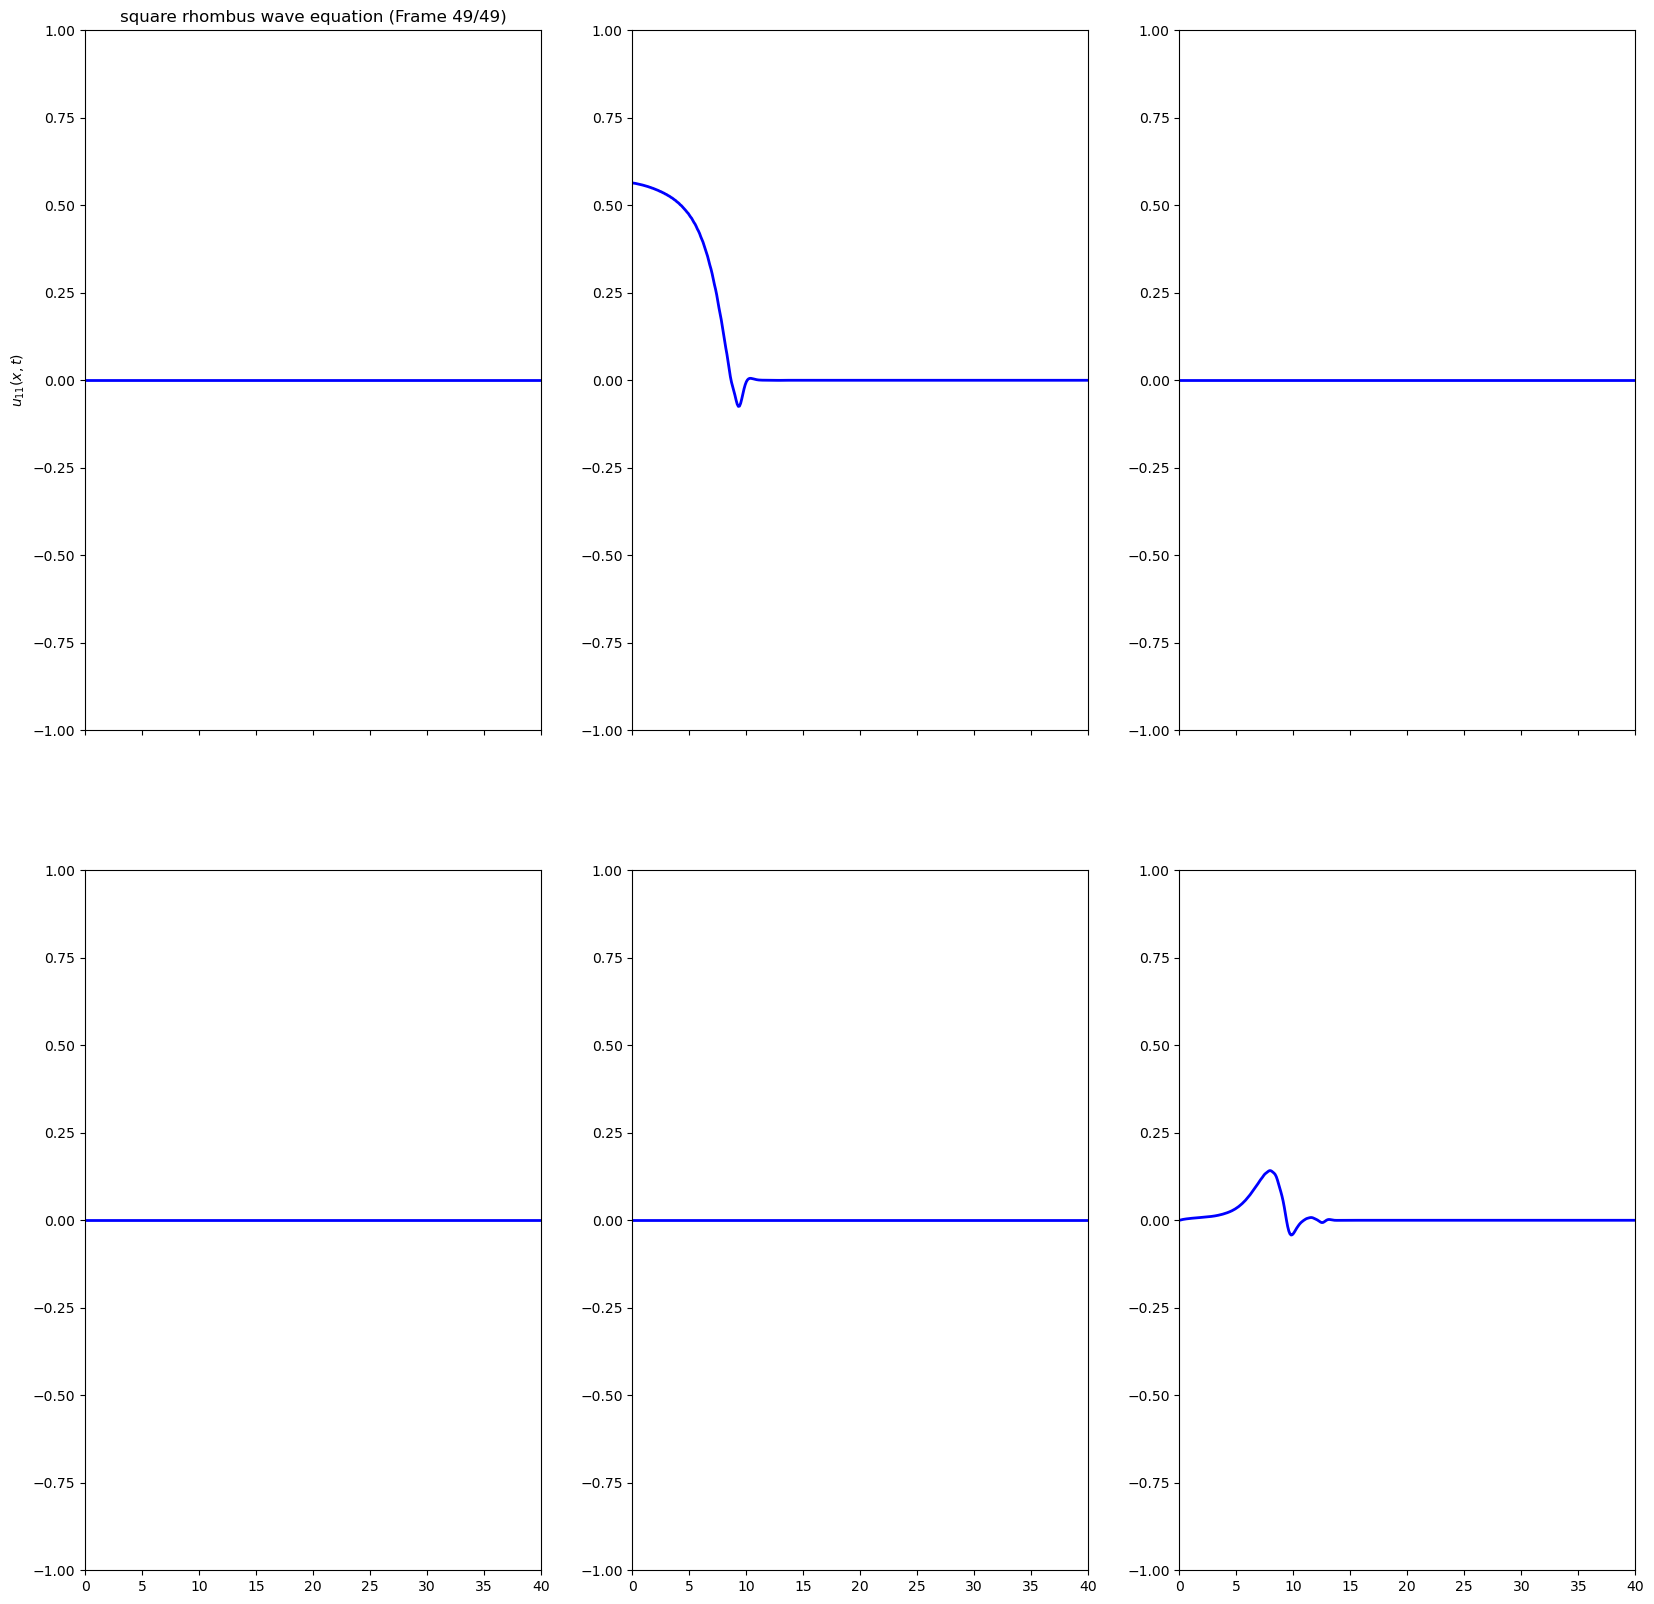

In [19]:
L = 40
N = 400
dx = L/N
x = np.linspace(0, L, N+1)

dt = 0.01
num_steps = 1000

m1 = 2.093e-3
m2 = 2.093e-3
I1 = 18.11e-9
I2 = 18.11e-9
k = 19235
k_theta = 0.0427
theta0 = np.pi / 180 * 25
l = 11.3e-3 / 2

K = k_theta / (k * l**2)
alpha = l / (np.sqrt(I1 / m1))
theta0 = np.pi / 180 * 25

def left_bc_atan_func(t, amp, freq):
    return amp * np.arctan(2.0 * np.pi * freq * t)
def left_bc_gaussian_func(t, amp, t0, sigma):
    return amp * np.exp( -((t - t0)**2) / (2*sigma**2) )

u11_init = np.zeros_like(x)
w11_init = np.zeros_like(x)
u21_init = np.zeros_like(x)
w21_init = np.zeros_like(x)

v11_init = np.zeros_like(x) 
z11_init = np.zeros_like(x) 
v21_init = np.zeros_like(x)
z21_init = np.zeros_like(x)

theta11_init = np.zeros_like(x)
phi11_init = np.zeros_like(x)
theta21_init = np.zeros_like(x)
phi21_init = np.zeros_like(x)


state = (u11_init, w11_init, u21_init, w21_init, v11_init, z11_init, v21_init, z21_init, theta11_init, phi11_init, theta21_init, phi21_init)

snapshots_u11 = []
snapshots_u21 = []

snapshots_v11 = []
snapshots_v21 = []

snapshots_theta11 = []
snapshots_theta21 = []


store_interval = 20

current_time = 0.0

for step in range(num_steps):
    print(f"Step = {step} finished")

    u11, w11, u21, w21, v11, z11, v21, z21, theta11, phi11, theta21, phi21= state
    u21[0] = left_bc_atan_func(t=current_time, amp = 0.4, freq = 0.1)
    w21[0] = left_bc_gaussian_func(t=current_time, amp = 0.03, t0=3, sigma=5)
    v21[0] = 0
    z21[0] = 0
    theta21[0] = 0
    phi21[0] = 0
    state = (u11, w11, u21, w21, v11, z11, v21, z21, theta11, phi11, theta21, phi21)
    state = rk4_step(state, square_rhombus_coupled_wave_equations, current_time, dt, K, theta0, alpha, dx)

    current_time += dt

    if step % store_interval == 0:
        (u11_snap, w11_snap, u21_snap, w21_snap, v11_snap, z11_snap, v21_snap, z21_snap, theta11_snap, phi11_snap, theta21_snap, phi21_snap) = state
        snapshots_u11.append(u11_snap.copy())
        snapshots_u21.append(u21_snap.copy())
        snapshots_v11.append(v11_snap.copy())
        snapshots_v21.append(v21_snap.copy())
        snapshots_theta11.append(theta11_snap.copy())
        snapshots_theta21.append(theta21_snap.copy())
        
fig, axes = plt.subplots(2, 3, figsize=(20, 20), sharex=True)

# 将二维数组展开为一维数组
axes = axes.ravel()

# 解包展开后的 axes
axu11, axu21, axv11, axv21, axtheta11, axtheta21 = axes

lineu11, = axu11.plot([], [], 'b-', lw=2, label="u11")
lineu21, = axu21.plot([], [], 'b-', lw=2, label="u21")
linev11, = axv11.plot([], [], 'b-', lw=2, label="v11")
linev21, = axv21.plot([], [], 'b-', lw=2, label="v21")
linetheta11, = axtheta11.plot([], [], 'b-', lw=2, label="theta11")
linetheta21, = axtheta21.plot([], [], 'b-', lw=2, label="theta21")

axu11.set_xlim(0, L)
axu11.set_ylim(-1, 1)
axu21.set_ylim(-1, 1)
axv11.set_ylim(-1, 1)
axv21.set_ylim(-1, 1)
axtheta11.set_ylim(-1, 1)
axtheta21.set_ylim(-1, 1)
axu11.set_ylabel(r"$u_{11}(x, t)$")
axu11.set_title("square rhombus wave equation")

def init():
    lineu11.set_data([], [])
    lineu21.set_data([], [])
    linev11.set_data([], [])
    linev21.set_data([], [])
    linetheta11.set_data([], [])
    linetheta21.set_data([], [])
    return (lineu11, lineu21, linev11, linev21, linetheta11, linetheta21)

def animate(frame_idx):
    lineu11.set_data(x, snapshots_u11[frame_idx])
    lineu21.set_data(x, snapshots_u21[frame_idx])
    linev11.set_data(x, snapshots_v11[frame_idx])
    linev21.set_data(x, snapshots_v21[frame_idx])
    linetheta11.set_data(x, snapshots_theta11[frame_idx])
    linetheta21.set_data(x, snapshots_theta21[frame_idx])
    axu11.set_title(f"square rhombus wave equation (Frame {frame_idx}/{len(snapshots_u11)-1})")
    return (lineu11, lineu21, linev11, linev21, linetheta11, linetheta21)

ani = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(snapshots_u11), interval=50, blit=True
)

ani.save("square_rhombus_block_wave_monotomic.gif", writer='pillow', fps=20)

plt.show()